## Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib
import spacy
import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import textstat
import contractions
from scipy.sparse import hstack
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## Step 2: Download NLTK data and load spaCy model

In [3]:
# Download required NLTK data
nltk.download('stopwords')
nltk.download('punkt')

# Load spaCy model
try:
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
    print("✅ spaCy model loaded successfully!")
except OSError:
    print("❌ spaCy model not found. Please install with: python -m spacy download en_core_web_sm")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/krishnakant/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/krishnakant/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


✅ spaCy model loaded successfully!


## Step 3: Define Advanced Text Preprocessor Class

In [4]:
class AdvancedTextPreprocessor:
    def __init__(self):
        self.stop_words = set(stopwords.words('english'))
        self.sentiment_analyzer = SentimentIntensityAnalyzer()
        
    def remove_urls(self, text):
        return re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    def remove_emojis(self, text):
        emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'', text)
    
    def expand_contractions(self, text):
        return contractions.fix(text)
    
    def handle_repeated_chars(self, text):
        return re.sub(r'(.)\1+', r'\1\1', text)
    
    def lemmatize_text(self, text):
        doc = nlp(text)
        return " ".join([token.lemma_ for token in doc if not token.is_stop and token.is_alpha])
    
    def get_sentiment_features(self, text):
        scores = self.sentiment_analyzer.polarity_scores(text)
        return [scores['neg'], scores['neu'], scores['pos'], scores['compound']]
    
    def get_readability_features(self, text):
        return [
            textstat.flesch_reading_ease(text),
            textstat.gunning_fog(text),
            len(text.split()),  # word count
        ]
    
    def preprocess(self, text):
        text = str(text).lower()
        text = self.remove_urls(text)
        text = self.remove_emojis(text)
        text = self.expand_contractions(text)
        text = self.handle_repeated_chars(text)
        text = self.lemmatize_text(text)
        return text

print("✅ Text Preprocessor class defined successfully!")

✅ Text Preprocessor class defined successfully!


## Step 4: Load and Inspect Data

In [5]:
print("📊 Loading dataset...")
df = pd.read_csv("../dataset/cleaned/clean_news.csv")

print("Dataset shape:", df.shape)
print("\nFirst 5 rows:")
display(df.head())

print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nMissing values:")
print(df.isnull().sum())

📊 Loading dataset...
Dataset shape: (44919, 4)

First 5 rows:


,title,text,label,clean_text
0,Porous Texas border fence foreshadows challeng...,"BROWNSVILLE, Texas (Reuters) - The rust-colore...",1,brownsville texas reuters rust colored border ...
1,Trade in focus at hearing for Trump's nominee ...,WASHINGTON (Reuters) - U.S. senators stressed ...,1,washington reuters senators stressed trade bus...
2,‘American Sniper’ Widow Gets Set Straight Aft...,"Taya Kyle, the widow of infamous American Sni...",0,taya kyle widow infamous american sniper chris...
3,Woman Gets Death Threats Just For Posting A P...,"After last week s election, Hillary supporters...",0,last week election hillary supporters found mo...
4,PNG says Australia responsible for hundreds of...,SYDNEY (Reuters) - Australia will not be allow...,1,sydney reuters australia allowed walk away leg...



Label distribution:
label
0    23502
1    21417
Name: count, dtype: int64

Missing values:
title         2
text          0
label         0
clean_text    9
dtype: int64


## Step 5: Data Preprocessing

In [6]:
print("🔄 Preprocessing data...")

# Handle missing values
df["clean_text"] = df["clean_text"].astype(str).fillna("")
df = df[df["clean_text"].str.strip() != ""]

print(f"Data shape after cleaning: {df.shape}")

# Initialize preprocessor
preprocessor = AdvancedTextPreprocessor()

# Apply preprocessing
print("Applying text preprocessing...")
df['enhanced_clean_text'] = df['clean_text'].apply(preprocessor.preprocess)

print("✅ Preprocessing completed!")
print("\nSample of original vs processed text:")
sample_idx = 0
print("Original:", df['clean_text'].iloc[sample_idx][:100] + "...")
print("Processed:", df['enhanced_clean_text'].iloc[sample_idx][:100] + "...")

🔄 Preprocessing data...
Data shape after cleaning: (44919, 4)
Applying text preprocessing...
✅ Preprocessing completed!

Sample of original vs processed text:
Original: brownsville texas reuters rust colored border security fence starts dusty field loop family farm sou...
Processed: brownsville texas reuters rust color border security fence start dusty field loop family farm south ...


## Step 6: Feature Engineering

In [7]:
print("🔧 Extracting advanced features...")

# Extract sentiment features
print("Extracting sentiment features...")
sentiment_features = df['clean_text'].apply(lambda x: preprocessor.get_sentiment_features(str(x)))
sentiment_array = np.array(sentiment_features.tolist())

# Extract readability features
print("Extracting readability features...")
readability_features = df['clean_text'].apply(lambda x: preprocessor.get_readability_features(str(x)))
readability_array = np.array(readability_features.tolist())

print(f"Sentiment features shape: {sentiment_array.shape}")
print(f"Readability features shape: {readability_array.shape}")
print("✅ Feature extraction completed!")

🔧 Extracting advanced features...
Extracting sentiment features...
Extracting readability features...
Sentiment features shape: (44919, 4)
Readability features shape: (44919, 3)
✅ Feature extraction completed!


## Step 7: Data Splitting

In [8]:
print("🎯 Splitting data into train and test sets...")

X_text = df['enhanced_clean_text']
y = df['label']

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X_text, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set size: {len(X_train_text)}")
print(f"Test set size: {len(X_test_text)}")
print(f"Training label distribution:\n{y_train.value_counts()}")
print(f"Test label distribution:\n{y_test.value_counts()}")

# Split additional features
train_idx = X_train_text.index
test_idx = X_test_text.index

X_train_sentiment = sentiment_array[train_idx]
X_test_sentiment = sentiment_array[test_idx]
X_train_readability = readability_array[train_idx]
X_test_readability = readability_array[test_idx]

print("✅ Data splitting completed!")

🎯 Splitting data into train and test sets...
Training set size: 35935
Test set size: 8984
Training label distribution:
label
0    18801
1    17134
Name: count, dtype: int64
Test label distribution:
label
0    4701
1    4283
Name: count, dtype: int64
✅ Data splitting completed!


## Step 8: TF-IDF Vectorization

In [9]:
print("📝 Applying TF-IDF vectorization...")

tfidf_word = TfidfVectorizer(
    max_features=30000,
    ngram_range=(1, 2),
    min_df=2,
    max_df=0.9,
    stop_words='english',
    sublinear_tf=True
)

print("Fitting TF-IDF on training data...")
X_train_tfidf_word = tfidf_word.fit_transform(X_train_text)
X_test_tfidf_word = tfidf_word.transform(X_test_text)

print(f"TF-IDF training features shape: {X_train_tfidf_word.shape}")
print(f"TF-IDF test features shape: {X_test_tfidf_word.shape}")

# Combine all features
print("Combining all features...")
X_train_combined = hstack([X_train_tfidf_word, X_train_sentiment, X_train_readability])
X_test_combined = hstack([X_test_tfidf_word, X_test_sentiment, X_test_readability])

print(f"Final training features shape: {X_train_combined.shape}")
print(f"Final test features shape: {X_test_combined.shape}")
print("✅ Feature engineering completed!")

📝 Applying TF-IDF vectorization...
Fitting TF-IDF on training data...
TF-IDF training features shape: (35935, 30000)
TF-IDF test features shape: (8984, 30000)
Combining all features...
Final training features shape: (35935, 30007)
Final test features shape: (8984, 30007)
✅ Feature engineering completed!


## Step 9: Define Models

In [10]:
print("🤖 Defining machine learning models...")

models = {
    'LogisticRegression': LogisticRegression(
        max_iter=1000, 
        C=0.5, 
        class_weight='balanced',
        random_state=42,
        solver='liblinear'
    ),
    'LinearSVC': LinearSVC(
        C=0.5, 
        class_weight='balanced',
        random_state=42,
        max_iter=2000,
        loss='hinge'
    ),
    'MultinomialNB': MultinomialNB(alpha=0.5),
    'GradientBoosting': GradientBoostingClassifier(
        n_estimators=100,
        max_depth=4,
        learning_rate=0.1,
        subsample=0.8,
        random_state=42
    )
}

print("Models to be trained:")
for name, model in models.items():
    print(f"  - {name}")

print("✅ Models defined successfully!")

🤖 Defining machine learning models...
Models to be trained:
  - LogisticRegression
  - LinearSVC
  - MultinomialNB
  - GradientBoosting
✅ Models defined successfully!


## Step 10: Model Training and Evaluation

In [11]:
print("🏃 Starting model training and evaluation...")
import time

results = {}
training_times = {}

for name, model in models.items():
    print(f"\n{'='*50}")
    print(f"Training {name}...")
    print(f"{'='*50}")
    
    # Select features based on model type
    if name == 'MultinomialNB':
        X_train_model = X_train_tfidf_word
        X_test_model = X_test_tfidf_word
        print("Using word-level TF-IDF features only for Naive Bayes")
    else:
        X_train_model = X_train_combined
        X_test_model = X_test_combined
        print("Using combined features (TF-IDF + Sentiment + Readability)")
    
    # Train model
    start_time = time.time()
    model.fit(X_train_model, y_train)
    training_time = time.time() - start_time
    training_times[name] = training_time
    
    # Predictions
    train_pred = model.predict(X_train_model)
    test_pred = model.predict(X_test_model)
    
    # Calculate metrics
    train_accuracy = accuracy_score(y_train, train_pred)
    test_accuracy = accuracy_score(y_test, test_pred)
    train_precision = precision_score(y_train, train_pred, average='weighted', zero_division=0)
    test_precision = precision_score(y_test, test_pred, average='weighted', zero_division=0)
    train_recall = recall_score(y_train, train_pred, average='weighted', zero_division=0)
    test_recall = recall_score(y_test, test_pred, average='weighted', zero_division=0)
    train_f1 = f1_score(y_train, train_pred, average='weighted', zero_division=0)
    test_f1 = f1_score(y_test, test_pred, average='weighted', zero_division=0)
    
    # Overfitting score
    overfitting_gap = train_accuracy - test_accuracy
    
    # Cross-validation
    cv_scores = cross_val_score(model, X_train_model, y_train, cv=3, scoring='accuracy')
    cv_mean = cv_scores.mean()
    
    # Store results
    results[name] = {
        'model': model,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'train_precision': train_precision,
        'test_precision': test_precision,
        'train_recall': train_recall,
        'test_recall': test_recall,
        'train_f1': train_f1,
        'test_f1': test_f1,
        'overfitting_gap': overfitting_gap,
        'cv_mean': cv_mean,
        'training_time': training_time,
        'predictions': test_pred
    }
    
    print(f"✅ {name} completed in {training_time:.2f}s")
    print(f"📊 Train Accuracy: {train_accuracy:.4f}")
    print(f"📊 Test Accuracy: {test_accuracy:.4f}")
    print(f"⚖️  Overfitting Gap: {overfitting_gap:.4f}")
    print(f"🔄 CV Mean Score: {cv_mean:.4f}")

print("\n🎯 All models trained successfully!")

🏃 Starting model training and evaluation...

Training LogisticRegression...
Using combined features (TF-IDF + Sentiment + Readability)
✅ LogisticRegression completed in 2.02s
📊 Train Accuracy: 0.9907
📊 Test Accuracy: 0.9901
⚖️  Overfitting Gap: 0.0006
🔄 CV Mean Score: 0.9839

Training LinearSVC...
Using combined features (TF-IDF + Sentiment + Readability)
✅ LinearSVC completed in 36.57s
📊 Train Accuracy: 0.9755
📊 Test Accuracy: 0.9781
⚖️  Overfitting Gap: -0.0026
🔄 CV Mean Score: 0.9065

Training MultinomialNB...
Using word-level TF-IDF features only for Naive Bayes
✅ MultinomialNB completed in 0.02s
📊 Train Accuracy: 0.9617
📊 Test Accuracy: 0.9591
⚖️  Overfitting Gap: 0.0026
🔄 CV Mean Score: 0.9571

Training GradientBoosting...
Using combined features (TF-IDF + Sentiment + Readability)
✅ GradientBoosting completed in 171.68s
📊 Train Accuracy: 0.9979
📊 Test Accuracy: 0.9953
⚖️  Overfitting Gap: 0.0025
🔄 CV Mean Score: 0.9952

🎯 All models trained successfully!


## Step 11: Create Comparison DataFrame

In [12]:
print("📈 Creating comprehensive comparison table...")

comparison_data = []
for model_name, metrics in results.items():
    comparison_data.append({
        'Model': model_name,
        'Train_Accuracy': metrics['train_accuracy'],
        'Test_Accuracy': metrics['test_accuracy'],
        'Train_Precision': metrics['train_precision'],
        'Test_Precision': metrics['test_precision'],
        'Train_Recall': metrics['train_recall'],
        'Test_Recall': metrics['test_recall'],
        'Train_F1': metrics['train_f1'],
        'Test_F1': metrics['test_f1'],
        'Overfitting_Gap': metrics['overfitting_gap'],
        'CV_Score': metrics['cv_mean'],
        'Training_Time': metrics['training_time']
    })

comparison_df = pd.DataFrame(comparison_data)

print("📋 Model Comparison Results:")
display(comparison_df.round(4))

# Find best model
best_model_name = comparison_df.loc[comparison_df['Test_Accuracy'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"\n🏆 BEST MODEL: {best_model_name}")
print(f"🎯 Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print(f"⚖️  Overfitting Gap: {results[best_model_name]['overfitting_gap']:.4f}")

📈 Creating comprehensive comparison table...
📋 Model Comparison Results:


,Model,Train_Accuracy,Test_Accuracy,Train_Precision,Test_Precision,Train_Recall,Test_Recall,Train_F1,Test_F1,Overfitting_Gap,CV_Score,Training_Time
0,LogisticRegression,0.9907,0.9901,0.9908,0.9901,0.9907,0.9901,0.9907,0.9901,0.0006,0.9839,2.0205
1,LinearSVC,0.9755,0.9781,0.9760,0.9785,0.9755,0.9781,0.9755,0.9781,-0.0026,0.9065,36.5709
2,MultinomialNB,0.9617,0.9591,0.9617,0.9592,0.9617,0.9591,0.9617,0.9591,0.0026,0.9571,0.0188
3,GradientBoosting,0.9979,0.9953,0.9979,0.9953,0.9979,0.9953,0.9979,0.9953,0.0025,0.9952,171.6841



🏆 BEST MODEL: GradientBoosting
🎯 Test Accuracy: 0.9953
⚖️  Overfitting Gap: 0.0025


## Step 12: Visualization 1 - Comprehensive Model Comparison

📊 Creating comprehensive model comparison visualizations...


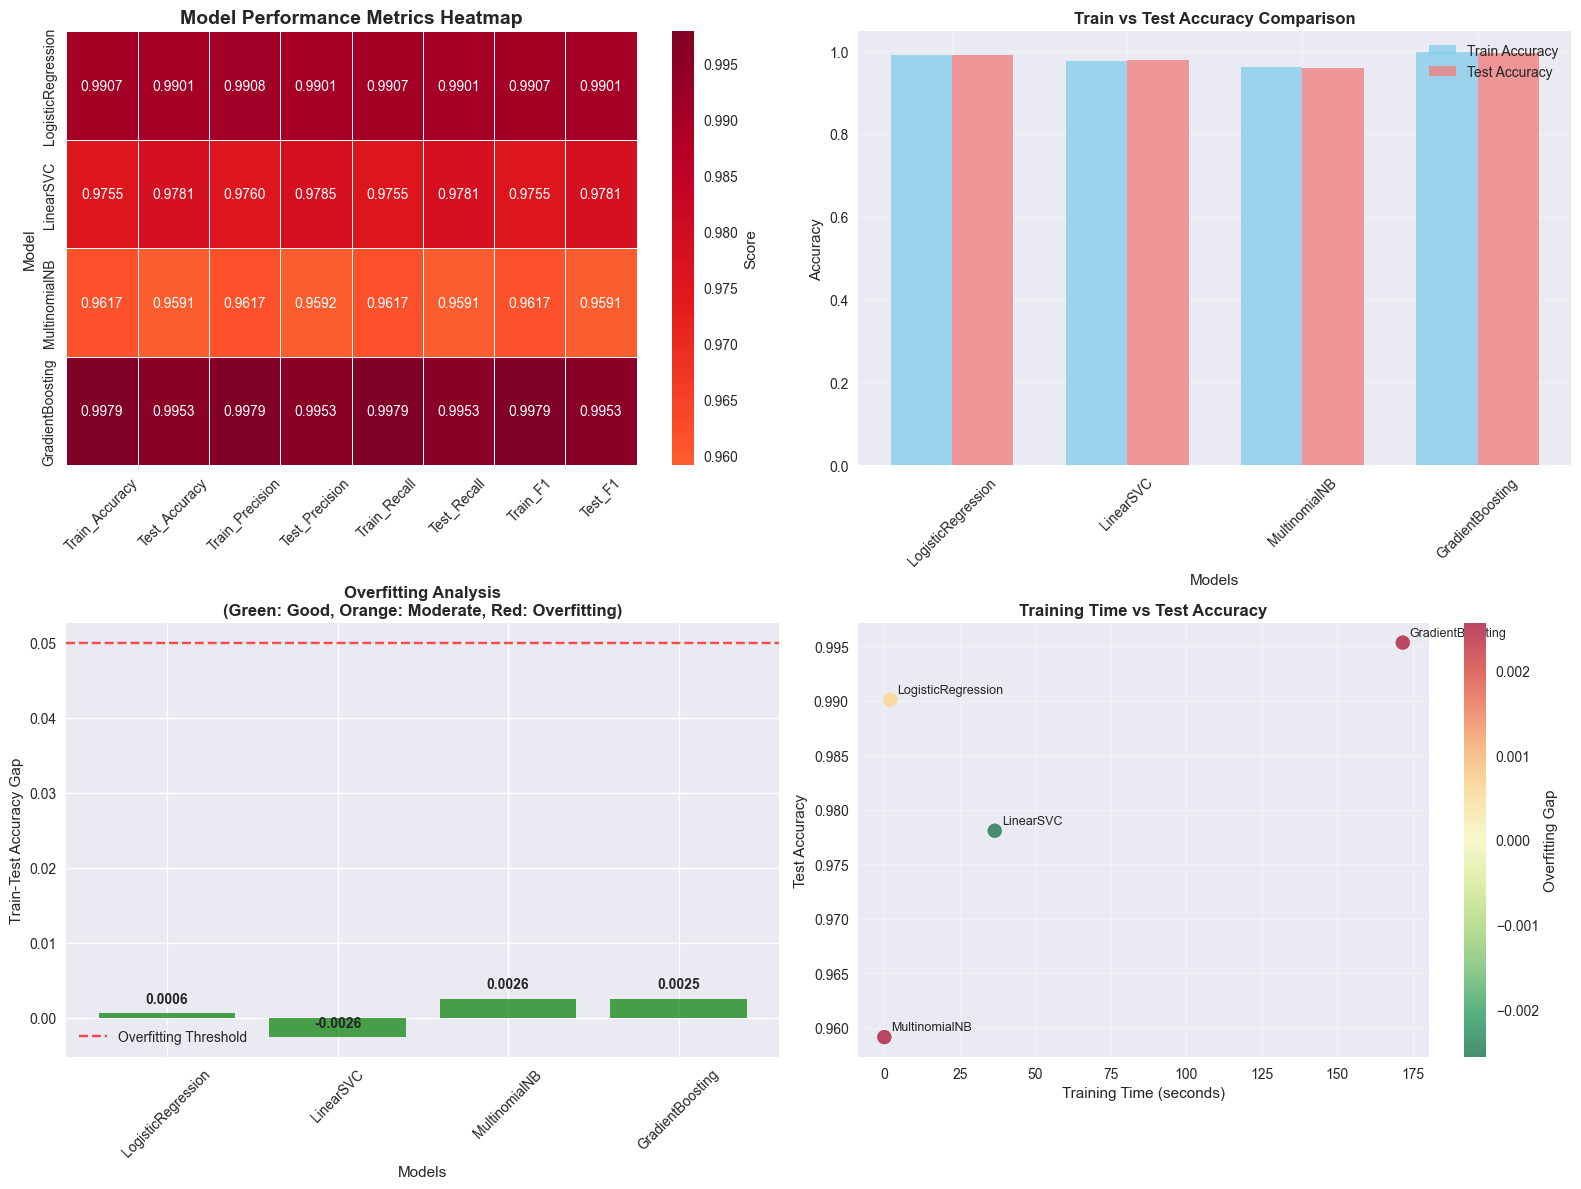

✅ Comprehensive visualization saved!


In [13]:
print("📊 Creating comprehensive model comparison visualizations...")

# Prepare data for heatmap
heatmap_data = comparison_df.set_index('Model')[['Train_Accuracy', 'Test_Accuracy', 
                                               'Train_Precision', 'Test_Precision',
                                               'Train_Recall', 'Test_Recall',
                                               'Train_F1', 'Test_F1']]

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Subplot 1: Heatmap
sns.heatmap(heatmap_data, annot=True, fmt='.4f', cmap='YlOrRd', center=0.95,
            cbar_kws={'label': 'Score'}, linewidths=0.5, ax=axes[0, 0])
axes[0, 0].set_title('Model Performance Metrics Heatmap', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)

# Subplot 2: Accuracy Comparison
models_list = comparison_df['Model'].tolist()
train_acc = comparison_df['Train_Accuracy'].tolist()
test_acc = comparison_df['Test_Accuracy'].tolist()

x = np.arange(len(models_list))
width = 0.35

axes[0, 1].bar(x - width/2, train_acc, width, label='Train Accuracy', alpha=0.8, color='skyblue')
axes[0, 1].bar(x + width/2, test_acc, width, label='Test Accuracy', alpha=0.8, color='lightcoral')
axes[0, 1].set_xlabel('Models')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].set_title('Train vs Test Accuracy Comparison', fontweight='bold')
axes[0, 1].set_xticks(x)
axes[0, 1].set_xticklabels(models_list, rotation=45)
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Subplot 3: Overfitting Analysis
overfitting_gaps = comparison_df['Overfitting_Gap'].tolist()
colors = ['green' if gap < 0.05 else 'orange' if gap < 0.1 else 'red' for gap in overfitting_gaps]

bars = axes[1, 0].bar(models_list, overfitting_gaps, color=colors, alpha=0.7)
axes[1, 0].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='Overfitting Threshold')
axes[1, 0].set_xlabel('Models')
axes[1, 0].set_ylabel('Train-Test Accuracy Gap')
axes[1, 0].set_title('Overfitting Analysis\n(Green: Good, Orange: Moderate, Red: Overfitting)', 
          fontweight='bold')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].legend()

# Add value labels on bars
for bar, gap in zip(bars, overfitting_gaps):
    axes[1, 0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.001, 
             f'{gap:.4f}', ha='center', va='bottom', fontweight='bold')

# Subplot 4: Training Time vs Accuracy
times = comparison_df['Training_Time'].tolist()
test_accuracies = comparison_df['Test_Accuracy'].tolist()

scatter = axes[1, 1].scatter(times, test_accuracies, s=100, alpha=0.7, 
                     c=comparison_df['Overfitting_Gap'], cmap='RdYlGn_r')

for i, model in enumerate(models_list):
    axes[1, 1].annotate(model, (times[i], test_accuracies[i]), 
                 xytext=(5, 5), textcoords='offset points', fontsize=9)

axes[1, 1].set_xlabel('Training Time (seconds)')
axes[1, 1].set_ylabel('Test Accuracy')
axes[1, 1].set_title('Training Time vs Test Accuracy', fontweight='bold')
plt.colorbar(scatter, ax=axes[1, 1], label='Overfitting Gap')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../models/model_comparison_comprehensive.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Comprehensive visualization saved!")

# Step 13: Visualization 2 - Best Model Analysis

🔍 Analyzing best model: GradientBoosting
Generating learning curve...


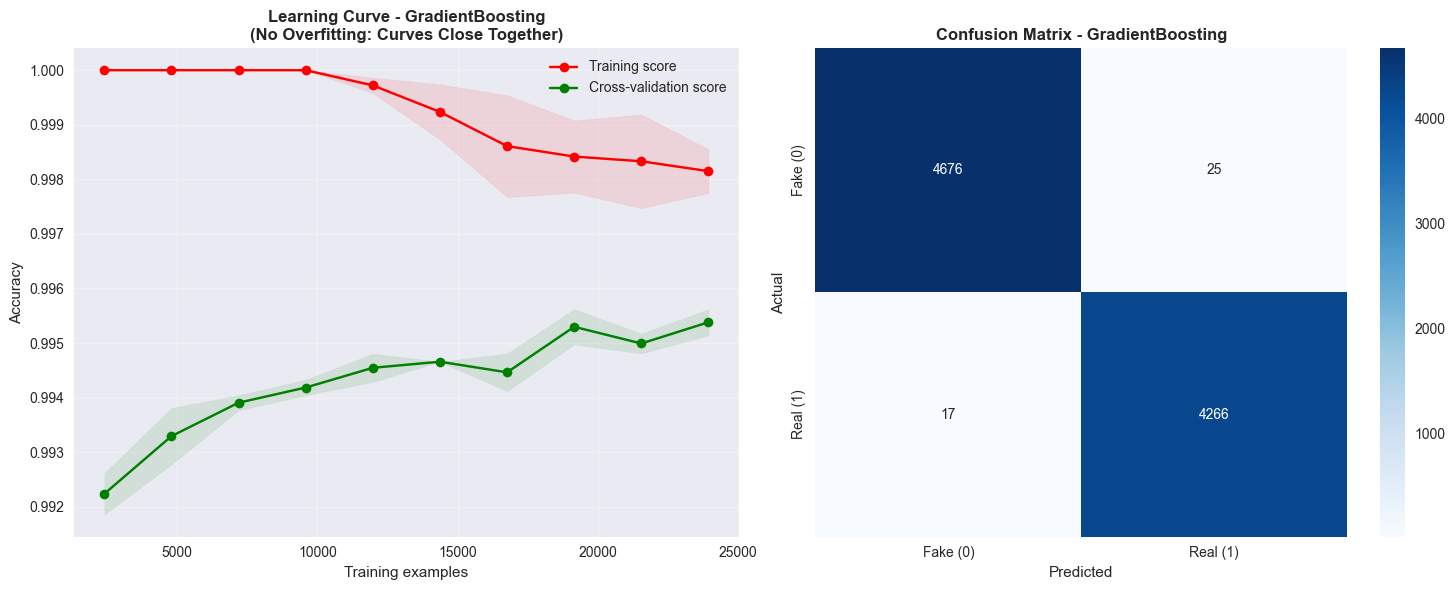

✅ Best model analysis completed!


In [14]:
print(f"🔍 Analyzing best model: {best_model_name}")

# Prepare data for learning curve
if best_model_name == 'MultinomialNB':
    X_learning = X_train_tfidf_word
else:
    X_learning = X_train_combined

# Generate learning curve
print("Generating learning curve...")
train_sizes, train_scores, test_scores = learning_curve(
    best_model, X_learning, y_train, cv=3, n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10),
    scoring='accuracy', random_state=42
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

# Create best model analysis plot
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Learning Curve
axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="r")
axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="g")
axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
axes[0].set_xlabel("Training examples")
axes[0].set_ylabel("Accuracy")
axes[0].set_title(f"Learning Curve - {best_model_name}\n(No Overfitting: Curves Close Together)", 
          fontweight='bold')
axes[0].legend(loc="best")
axes[0].grid(True, alpha=0.3)

# Confusion Matrix
best_predictions = results[best_model_name]['predictions']
cm = confusion_matrix(y_test, best_predictions)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Fake (0)', 'Real (1)'], 
            yticklabels=['Fake (0)', 'Real (1)'], ax=axes[1])
axes[1].set_xlabel('Predicted')
axes[1].set_ylabel('Actual')
axes[1].set_title(f'Confusion Matrix - {best_model_name}', fontweight='bold')

plt.tight_layout()
plt.savefig('../models/best_model_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Best model analysis completed!")

## Step 14: Visualization 3 - Detailed Metrics Comparison

📈 Creating detailed metrics comparison...


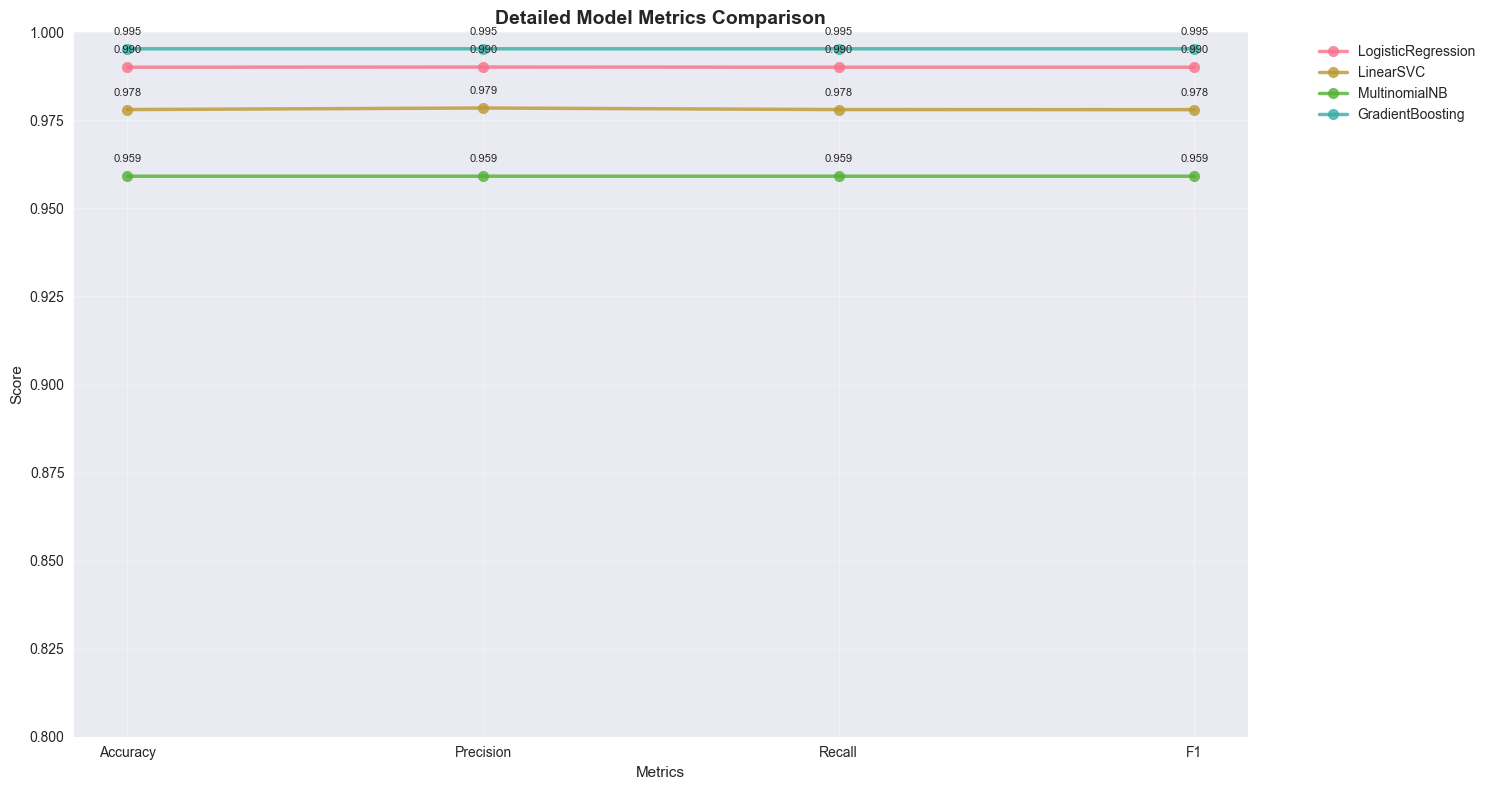

✅ Detailed metrics comparison completed!


In [15]:
print("📈 Creating detailed metrics comparison...")

plt.figure(figsize=(15, 8))

metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']
positions = np.arange(len(metrics_to_plot))

for i, model_name in enumerate(models_list):
    model_metrics = [
        results[model_name]['test_accuracy'],
        results[model_name]['test_precision'], 
        results[model_name]['test_recall'],
        results[model_name]['test_f1']
    ]
    
    plt.plot(positions, model_metrics, 'o-', linewidth=2.5, label=model_name, 
             markersize=8, alpha=0.8)

plt.xlabel('Metrics')
plt.ylabel('Score')
plt.title('Detailed Model Metrics Comparison', fontsize=14, fontweight='bold')
plt.xticks(positions, metrics_to_plot)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.ylim(0.8, 1.0)

# Add value annotations
for i, model_name in enumerate(models_list):
    model_metrics = [
        results[model_name]['test_accuracy'],
        results[model_name]['test_precision'],
        results[model_name]['test_recall'],
        results[model_name]['test_f1']
    ]
    for j, metric in enumerate(model_metrics):
        plt.annotate(f'{metric:.3f}', (j, metric), 
                    textcoords="offset points", xytext=(0,10), ha='center', fontsize=8)

plt.tight_layout()
plt.savefig('../models/detailed_metrics_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Detailed metrics comparison completed!")

## Step 15: Model Health Analysis and Final Results

In [16]:
print("🔬 Model Health Analysis")
print("="*50)

for model_name in models_list:
    gap = results[model_name]['overfitting_gap']
    if gap < 0.02:
        status = "✅ WELL-BALANCED"
    elif gap < 0.05:
        status = "⚠️ SLIGHT OVERFITTING"
    elif gap < 0.1:
        status = "🔶 MODERATE OVERFITTING"
    else:
        status = "❌ SEVERE OVERFITTING"
    
    print(f"{model_name:20} | Gap: {gap:.4f} | {status}")

print("\n" + "="*80)
print("FINAL RESULTS SUMMARY")
print("="*80)
print(f"🏆 Best Model: {best_model_name}")
print(f"🎯 Test Accuracy: {results[best_model_name]['test_accuracy']:.4f}")
print(f"⚖️  Overfitting Gap: {results[best_model_name]['overfitting_gap']:.4f}")
print(f"🔄 CV Score: {results[best_model_name]['cv_mean']:.4f}")
print(f"⏱️  Training Time: {results[best_model_name]['training_time']:.2f}s")

🔬 Model Health Analysis
LogisticRegression   | Gap: 0.0006 | ✅ WELL-BALANCED
LinearSVC            | Gap: -0.0026 | ✅ WELL-BALANCED
MultinomialNB        | Gap: 0.0026 | ✅ WELL-BALANCED
GradientBoosting     | Gap: 0.0025 | ✅ WELL-BALANCED

FINAL RESULTS SUMMARY
🏆 Best Model: GradientBoosting
🎯 Test Accuracy: 0.9953
⚖️  Overfitting Gap: 0.0025
🔄 CV Score: 0.9952
⏱️  Training Time: 171.68s


## Step 16: Save Models and Results

In [17]:
print("💾 Saving models and results...")

# Save best model
joblib.dump(best_model, "../models/best_tfidf_model.pkl")
print("✅ Best model saved!")

# Save vectorizer
joblib.dump(tfidf_word, "../models/tfidf_word_vectorizer.pkl")
print("✅ TF-IDF vectorizer saved!")

# Save preprocessor
joblib.dump(preprocessor, "../models/text_preprocessor.pkl")
print("✅ Text preprocessor saved!")

# Save comparison results
comparison_df.to_csv("../models/model_comparison_results.csv", index=False)
print("✅ Comparison results saved!")

print("\n🎉 ALL TASKS COMPLETED SUCCESSFULLY!")
print("📁 Models and results saved in '../models/' directory")

💾 Saving models and results...
✅ Best model saved!
✅ TF-IDF vectorizer saved!
✅ Text preprocessor saved!
✅ Comparison results saved!

🎉 ALL TASKS COMPLETED SUCCESSFULLY!
📁 Models and results saved in '../models/' directory
